In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

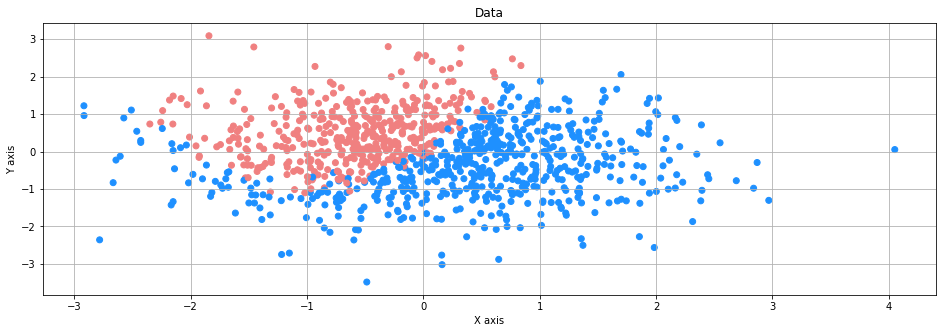

In [2]:
import matplotlib

colors = ['lightcoral', 'dodgerblue']


fileName = 'datosT1P3.txt'
data = np.genfromtxt(fileName, delimiter=',')


fig = plt.figure(0,(16,5))
plt.scatter(data[0,:],data[1,:], c=data[2,:], cmap = mcolors.ListedColormap(colors))
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()

plt.show(fig)

In [3]:
# module imports
from patsy import dmatrices
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm

# read in the data & create matrices
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
X = pd.DataFrame({'intercept': np.ones(data.shape[1]), 'feature1': data[0,:], 'feature2': data[1,:]})
y = pd.DataFrame({'target': data[2,:]})

#print(X)

# sklearn output
model = LogisticRegression(fit_intercept = False)
mdl = model.fit(X, y)
model.coef_

# sm
logit = sm.Logit(y, X)
beta = logit.fit().params
print(beta)

/home/lerko/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization terminated successfully.
         Current function value: 0.346926
         Iterations 7
feature1     2.231767
feature2    -2.196485
intercept    0.716651
dtype: float64


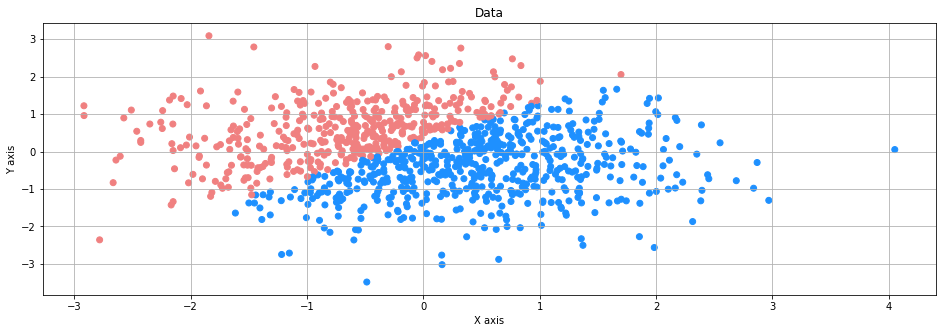

[[ 0.83610451  0.16389549]
 [ 0.10362694  0.89637306]]


In [4]:
from sklearn.metrics import confusion_matrix

predicted = model.predict(X)

fig = plt.figure(0,(16,5))
plt.scatter(data[0,:],data[1,:], c=predicted, cmap = mcolors.ListedColormap(colors))
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()

plt.show(fig)

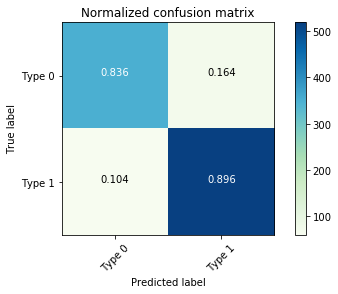

In [32]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],3)
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


confMatrix = confusion_matrix(data[2,:], predicted)
class_names = ['Type 0', 'Type 1']
plot_confusion_matrix(confMatrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.GnBu)
plt.show()

# Maximum A Posteriori Model

Sigmoid Model is given by:

$$
\text{sigmoid2D}(x_1,x_2) = \frac{1}{1+e^{-\beta_0 - \beta_1x_1 - \beta_2x_2}}
$$

In this case our prior over parameters are:

$$
\beta_0 \sim N(\beta^{init}_0, \sigma_0^2)\\
\beta_1 \sim N(\beta^{init}_1, \sigma_1^2)\\
\beta_2 \sim N(\beta^{init}_2, \sigma_2^2)
$$

Where $\beta_i^0$  $\forall i = 0, 1, 2$ are the values found in the past section.

Finally, we assume that each class distibutes as Bernoulli. That is mean:

$$
Y_{obs}(x^i) \sim Ber(p(x^i))\\
p(x^i) = \frac{1}{1+e^{-\beta_0 - \beta_1x_1^i-\beta_2x_2^i}}
$$

In [5]:
import theano.tensor as tt

def sigmoid2D(x1,x2, beta0, beta1, beta2):
    return 1.0/(1+tt.exp(-beta0 - beta1*x1-beta2*x2))

/home/lerko/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 10000/10000 [00:10<00:00, 910.93it/s]


beta_0: 0.716650629908
beta_1: 2.23176734006
beta_2: -2.19648475497
<MultiTrace: 1 chains, 10000 iterations, 3 variables>


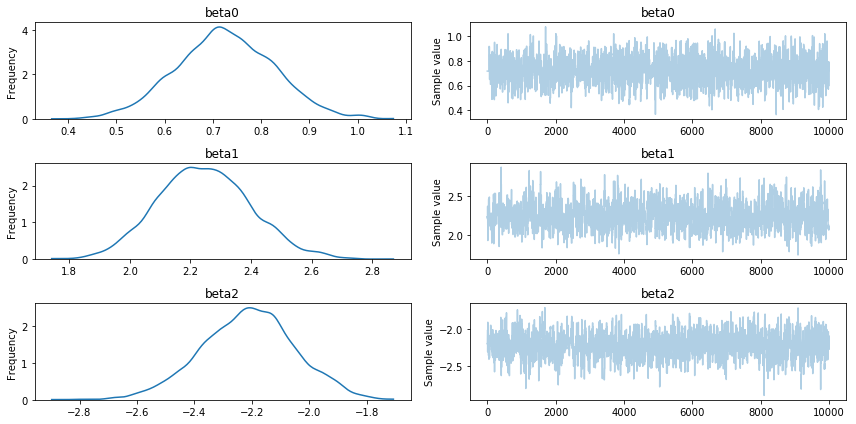

In [7]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    beta0 = pm.Normal('beta0', mu=beta['intercept'], sd=10)
    beta1 = pm.Normal('beta1', mu=beta['feature1'], sd=10)
    beta2 = pm.Normal('beta2', mu=beta['feature2'], sd=10)

    # Expected value of outcome
    p_sigmoid = sigmoid2D(data[0,:],data[1,:],beta0,beta1,beta2)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    # print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Bernoulli('Y_obs', p=p_sigmoid, observed=data[2,:])
    
    # sample using Metropolis
    step = pm.Metropolis()
    trace = pm.sample(10000, step)

print('beta_0: %s\nbeta_1: %s\nbeta_2: %s' % (beta['intercept'], beta['feature1'], beta['feature2']))
print(trace)
pm.traceplot(trace);
plt.show()